In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import joblib

In [4]:
# Step 1: Data Collection & Preprocessing
# Load dataset
csv_file_path = "/content/hypothyroid.csv"
df = pd.read_csv(csv_file_path)

# Conduct Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values Per Column:")
print(df.isnull().sum())
print("\nStatistical Summary of Numeric Columns:")
print(df.describe())

Dataset Overview:
  age sex on thyroxine query on thyroxine on antithyroid medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid surgery I131 treatment query hypothyroid  ...   T3  \
0        f               f              f                 f  ...  2.5   
1        f               f              f                 f  ...    2   
2        f               f              f                 f  ...    ?   
3        f               f              f                 f  ...  1.9   
4        f               f              f                 f  ...  1.2   

  TT4 measured  TT4 T4U measured   T4U FTI measured  FTI TBG measured  \
0            

In [5]:
import numpy as np
import pandas as pd

# Step 1: Remove rows containing "?" values by replacing with NaN and dropping them
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Step 2: Define binary columns
binary_cols = ['on thyroxine', 'query on thyroxine', 'on antithyroid medication',
               'sick', 'pregnant', 'thyroid surgery', 'I131 treatment',
               'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre',
               'tumor', 'hypopituitary', 'psych', 'TSH measured',
               'T3 measured', 'TT4 measured', 'T4U measured',
               'FTI measured', 'TBG measured']

# Step 3: Map binary columns to 0 and 1
for col in binary_cols:
    df[col] = df[col].map({'t': 1, 'f': 0}).astype('int64')  # Ensure compatible dtype



In [6]:
# Encode categorical columns
df['sex'] = df['sex'].map({'M': 1, 'F': 0})
df['binaryClass'] = df['binaryClass'].map({'P': 1, 'N': 0})
label_encoder = LabelEncoder()
df['referral source'] = label_encoder.fit_transform(df['referral source'])

In [7]:
# Separate features and target
X = df.drop('binaryClass', axis=1)
y = df['binaryClass']

In [8]:
# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)


In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Step 2: Model Training
# Initialize models
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
}

# Train and evaluate models
best_model = None
best_score = 0
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")


Training XGBoost...
Training Time: 0.13 seconds


In [12]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"{model_name} Performance:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Save the best model
if f1 > best_score:
    best_model = model
    best_score = f1



XGBoost Performance:
Accuracy: 0.9943, Precision: 0.9979, Recall: 0.9958, F1 Score: 0.9968


In [13]:
# Step 3: Model Evaluation
print("\nEvaluating the Best Model...")
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))


Evaluating the Best Model...
Confusion Matrix:
 [[ 52   1]
 [  2 474]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       1.00      1.00      1.00       476

    accuracy                           0.99       529
   macro avg       0.98      0.99      0.98       529
weighted avg       0.99      0.99      0.99       529



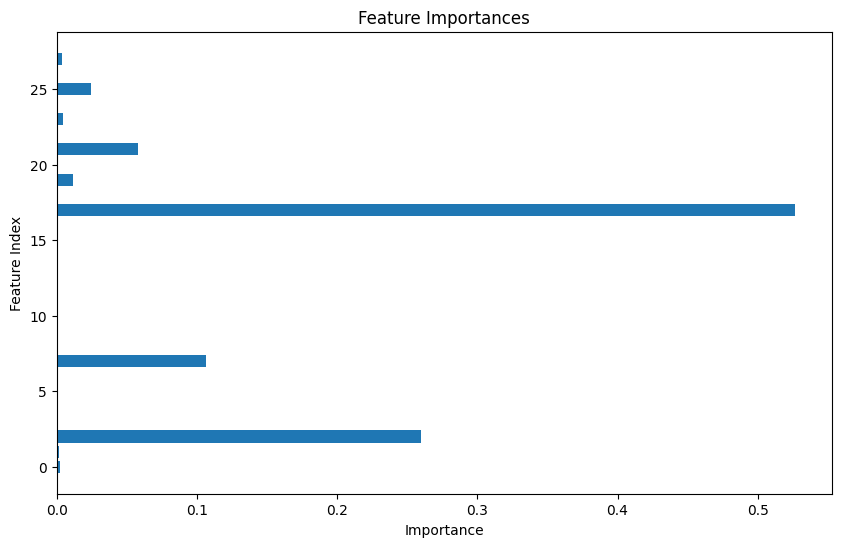

In [14]:
# Visualize Feature Importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature Index')
    plt.show()

In [15]:
# Step 4: Model Deployment
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("Model saved as 'best_model.pkl'.")

# Deployment Instructions
print("To deploy the model as an API, use a framework like Flask or FastAPI.")
print("""
Example Flask API:
------------------
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)
model = joblib.load('best_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prediction = model.predict([data['features']])
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)
""")

Model saved as 'best_model.pkl'.
To deploy the model as an API, use a framework like Flask or FastAPI.

Example Flask API:
------------------
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)
model = joblib.load('best_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prediction = model.predict([data['features']])
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)

